# Python的化学描述--rdkit

- rdkit的英文原版教程(cookbook)：http://www.rdkit.org/docs/Cookbook.html
- rdkit tutorials (jupyter):https://github.com/rdkit/rdkit-tutorials
- rdkit的中文教程：http://rdkit.chenzhaoqiang.com/

本文为cookbook的中译本。内容顺序稍作调整，以符合逻辑习惯。
翻译：张强

## 1 预备知识

我们知道，ChemDraw、ChemSK等常见的结构式编辑软件，结构式存储格式为cdx和sk2。这些是编辑软件常用格式，但在数据处理中不用

**数据处理需要的是结构化的人文本格式，数据交换方便，数据内容透明**
- mol
- mol2
- smiles
- Inchi-Key
- xyz（衍生的gjf、log等计算化学的文件格式）
 

可以从ChemDraw中查看这是数据的内容

## 2 分子读取与显示
### 2.1 读入分子描述并显示
可以读入smiles字符串、mol文本模块或加载mol文件等多种方式。加载成功后得到rdkit.Chem.rdchem.Mol 对象

In [2]:
from rdkit import Chem # 如果只是想读入分子，只导入chem就可以了
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #如果不想使用svg，改为False

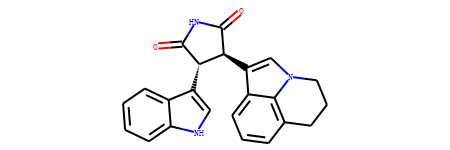

In [3]:
#读取smiles字符串，加载分子
mol = Chem.MolFromSmiles("C1CC2=C3C(=CC=C2)C(=CN3C1)[C@H]4[C@@H](C(=O)NC4=O)C5=CNC6=CC=CC=C65")
mol

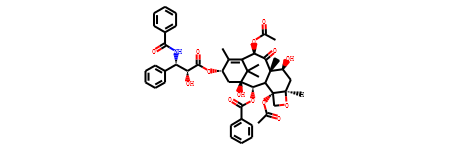

In [5]:
mol = Chem.MolFromMolFile('../data/taxol.mol')
mol

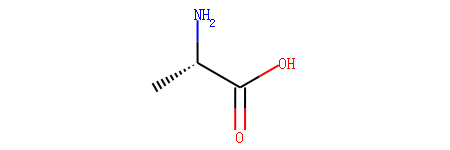

In [6]:
# 从mol文本加载分子
mol1 = Chem.MolFromMolBlock("""
     RDKit          2D

  6  5  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2990    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2990    2.2500    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5981   -1.5000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  2  1  1  6
  2  3  1  0
  2  4  1  0
  4  5  2  0
  4  6  1  0
M  END""")
mol1

### 2.2 给原子加编号
我们定义一个编号函数，遍历分子中的各个原子，然后添加编号，最后返回分子对象。

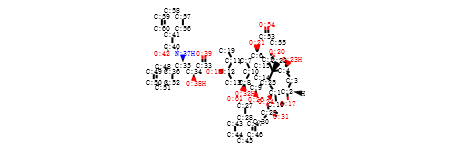

In [8]:
# 遍历分子中的原子，返回带编号的结构是
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

mol_with_atom_index(mol)

### 2.3 在分子结构上标记构型

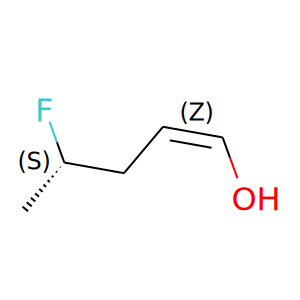

In [9]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def mol_with_stereo(mol,molSize=(300,300), kekulize=True, fontSize = 0.8, LineWidth = 1):
    # check for defective molecule
    if mol is None:
        return None

    mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.SetFontSize(fontSize)
    drawer.drawOptions().addStereoAnnotation = True
    # drawer.drawOptions().addAtomIndices = True

    try:
        drawer.SetLineWidth(LineWidth)
    except:
        pass

    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg
# 通常 drawer会获得更好的绘图效果
m = Chem.MolFromSmiles('C[C@H](F)C\C=C/O')
SVG(mol_with_stereo(m))

### 2.4 高亮亚结构

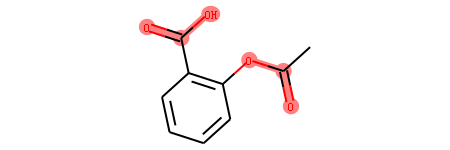

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
# 定义要高亮标记的亚结构，并匹配到分子对象中
substructure = Chem.MolFromSmarts('C(=O)O')
m.GetSubstructMatches(substructure)
m

### 2.5 加载分子表单
分子表单一般保存在sdf文件中。

8


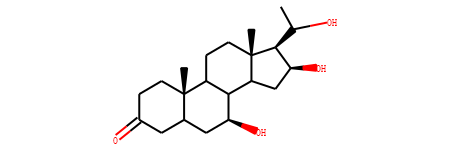

In [12]:
suppl = Chem.SDMolSupplier('../data/sdf-sample.sdf')
print(len(suppl))
suppl[0]

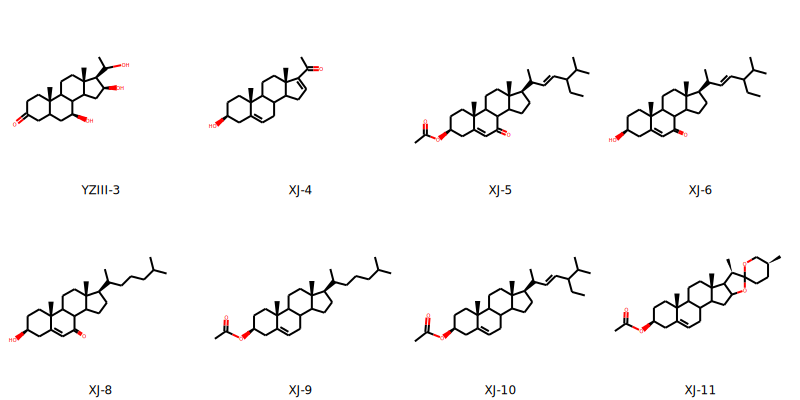

In [13]:
# 分子网格显示
Draw.MolsToGridImage(suppl,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("Orignal_NO") for x in suppl])    

## 3 分子属性标记
### 3.1 标记表面电荷

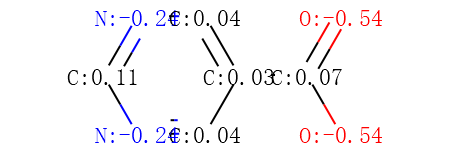

In [14]:
from rdkit.Chem import AllChem
m = Chem.MolFromSmiles('c1ncncc1C(=O)[O-]')
# 计算表面电荷
AllChem.ComputeGasteigerCharges(m)
# 遍历原子添加标记
for at in m.GetAtoms():
    lbl = '%s:%.2f'%(at.GetSymbol(),at.GetDoubleProp("_GasteigerCharge"))
    at.SetProp('atomLabel',lbl)
m

### 3.2 原子杂化类型

In [15]:
m = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
for x in m.GetAtoms():
    print(x.GetIdx(), x.GetHybridization())

# 获得SP3杂化原子数    
print(sum((x.GetHybridization() == Chem.HybridizationType.SP3) for x in m.GetAtoms()))

0 SP3
1 SP2
2 SP2
3 SP2
4 SP2
5 SP2
6 SP2
7 SP2
8 SP2
9 SP2
10 SP2
11 SP2
12 SP3
13 SP3
3


最后一条是复合语句。这种结构一般由内向外看。最内层通过for循环便利每个原子，然后每个原子通过GetHybridization()方法获得杂化类型。判断杂化类型是否为SP3，每个原子的结果要么是True，要么是False，组成元组。整个元组求和，True会自动转1，False会自动转0。总和也就是SP3杂化的原子数。最外层，也就是打印这个函数。<br/>
这种复合语句看上去很简洁，但易读性差一些。

In [7]:
sum((True,False,True,False,False,True))

3

In [8]:
# 我们把上面最后一条语句拆成一个语句块会更好理解。



### 2.3 环系识别 

**注意：** 多环体系也被当成一个环系对待

((1, 2, 4, 5, 6, 7, 8), (9, 10, 11, 12, 7, 8), (15, 16, 17, 18, 19, 14))


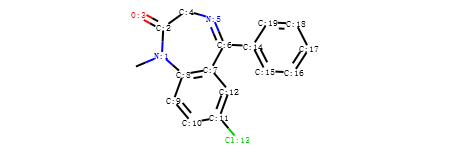

In [33]:
mol = Chem.MolFromSmiles('CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3')

#连续的.操作符，这一点是从Java和.NET借鉴过来的
print(mol.GetRingInfo().AtomRings())
mol_with_atom_index(mol)
# 这是二环体系

In [24]:
#获得组成环的化学键
ri = mol.GetRingInfo()
print(ri.BondRings())

((1, 3, 4, 5, 6, 7, 19), (9, 10, 11, 20, 7, 8), (15, 16, 17, 18, 21, 14))


In [34]:
# 判断给定的环是否为芳香环
# 依据：环上所有的原子都是芳香的，则环是方向的

def isRingAromatic(mol, bondRing):
        for id in bondRing:
            if not mol.GetBondWithIdx(id).GetIsAromatic():
                return False
        return True
    
print(isRingAromatic(mol, ri.BondRings()[0]))
print(isRingAromatic(mol, ri.BondRings()[1]))

False
True


### 2.4 识别手性中心

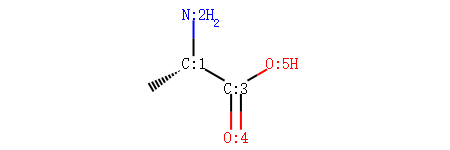

In [40]:
mol_with_atom_index(mol1)

In [36]:
Chem.AssignAtomChiralTagsFromStructure(mol1)
print(Chem.FindMolChiralCenters(mol1))

[(1, 'S')]


[(1, 'S')]


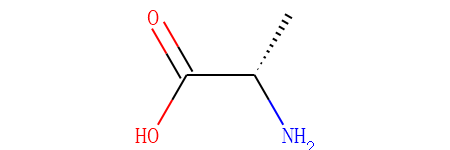

In [42]:
#从一个smiles字符串中找手性中心
mol2 = Chem.MolFromSmiles("C[C@H](N)C(=O)O")
Chem.AssignAtomChiralTagsFromStructure(mol2)
print(Chem.FindMolChiralCenters(mol2))
mol2

## 3 读取化合物列表

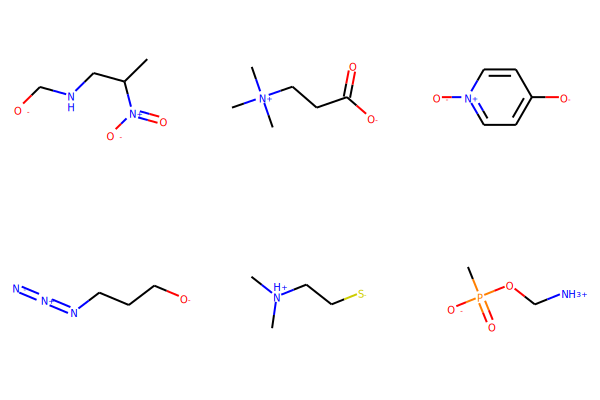

In [43]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# list of SMILES
smiList = ['CC(CNC[O-])[N+]([O-])=O',
       'C[N+](C)(C)CCC([O-])=O',
       '[O-]C1=CC=[N+]([O-])C=C1',
       '[O-]CCCN=[N+]=[N-]',
       'C[NH+](C)CC[S-]',
       'CP([O-])(=O)OC[NH3+]']

# Create RDKit molecular objects
mols = [Chem.MolFromSmiles(m) for m in smiList]

# display
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200))

## 4 匹配亚结构

((0, 22), (13, 14), (17, 18))


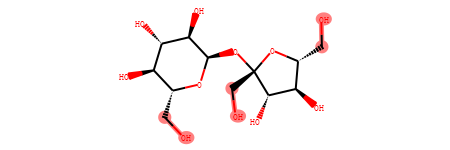

In [48]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
sucrose = "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@]2([C@H]([C@@H]([C@H](O2)CO)O)O)CO)O)O)O)O"
sucrose_mol = Chem.MolFromSmiles(sucrose)
primary_alcohol = Chem.MolFromSmarts("[CH2][OH1]")
print(sucrose_mol.GetSubstructMatches(primary_alcohol))
sucrose_mol

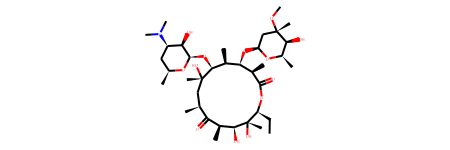

In [45]:
erythromycin = Chem.MolFromSmiles("CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O")
erythromycin

In [46]:
macro = Chem.MolFromSmarts("[r{12-}]")
print(erythromycin.GetSubstructMatches(macro))

((2,), (3,), (4,), (5,), (6,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (17,))


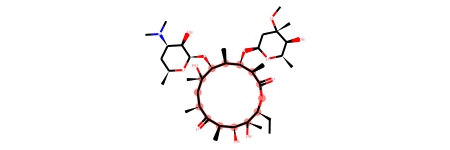

In [47]:
erythromycin

## 5 计算分子描述符

MW: 398.199428072
TPSA: 34.47
Num of Rotable Bonds: 5
Num of H donors: 0
Num of H acceptors: 4
logP: 4.666120000000004


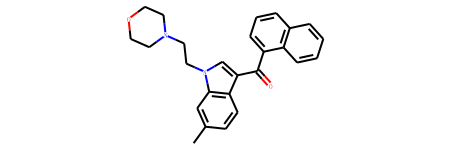

In [63]:
from rdkit.Chem import AllChem, Draw, Descriptors, Crippen

mol = Chem.MolFromSmiles('CC1=CC2=C(C=C1)C(=CN2CCN1CCOCC1)C(=O)C1=CC=CC2=C1C=CC=C2')

print('MW:', Descriptors.ExactMolWt(mol))
print('TPSA:', Chem.rdMolDescriptors.CalcTPSA(mol))
print('Num of Rotable Bonds:', Descriptors.NumRotatableBonds (mol))
print('Num of H donors:', Descriptors.NumHDonors(mol))
print('Num of H acceptors:', Descriptors.NumHAcceptors(mol))
print('logP:', Descriptors.MolLogP(mol))

mol

## 6 写分子

In [52]:
Chem.MolToSmiles(mol)

'Cc1ccc2c(C(=O)c3cccc4ccccc34)cn(CCN3CCOCC3)c2c1'

In [54]:
Chem.MolToInchi(mol)

'InChI=1S/C26H26N2O2/c1-19-9-10-22-24(26(29)23-8-4-6-20-5-2-3-7-21(20)23)18-28(25(22)17-19)12-11-27-13-15-30-16-14-27/h2-10,17-18H,11-16H2,1H3'

In [55]:
Chem.MolToInchiKey(mol)

'DDVFEKLZEPNGMS-UHFFFAOYSA-N'

In [62]:
print(Chem.MolToSmarts(mol))

[#6]-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1):[#6](:[#6]:[#7]:2-[#6]-[#6]-[#7]1-[#6]-[#6]-[#8]-[#6]-[#6]-1)-[#6](=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2


In [61]:
print(Chem.MolToMolBlock(mol))


     RDKit          2D

 30 34  0  0  0  0  0  0  0  0999 V2000
    9.5215   -5.4445    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    8.0950   -4.9810    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.9802   -5.9847    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.5537   -5.5211    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.2418   -4.0539    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3565   -3.0502    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.7831   -3.5137    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.7500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.1399   -5.2674    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.2546   -6.2711    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    4.0978   -7.7629    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.7275   -8.3730    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5707   -9.8648    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.2004  -10.4749    0

## 7 纠错

In [68]:
from rdkit import Chem
m = Chem.MolFromSmiles('CN(C)(C)C', sanitize=False)
problems = Chem.DetectChemistryProblems(m)
print(len(problems))
problems[0].Message()

1


'Explicit valence for atom # 1 N, 4, is greater than permitted'

## 8 有机反应

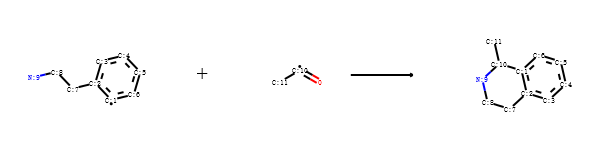

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
# Pictet-Spengler rxn
rxn = AllChem.ReactionFromSmarts('[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.[#6:11]-[CH1;R0:10]=[OD1]>>[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1')
rxn

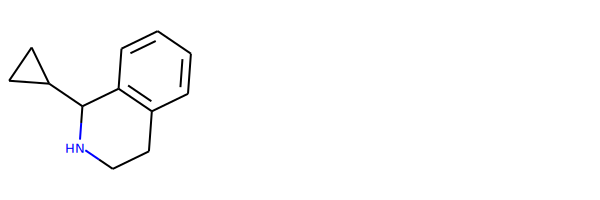

In [5]:
rxn2 = AllChem.ChemicalReaction()
for i in range(rxn.GetNumReactantTemplates()):
    rxn2.AddProductTemplate(rxn.GetReactantTemplate(i))
for i in range(rxn.GetNumProductTemplates()):
    rxn2.AddReactantTemplate(rxn.GetProductTemplate(i))
rxn2.Initialize()

reacts = [Chem.MolFromSmiles(x) for x in ('NCCc1ccccc1','C1CC1C(=O)')]
ps = rxn.RunReactants(reacts)
ps0 = ps[0]
for p in ps0:
    Chem.SanitizeMol(p)
Draw.MolsToGridImage(ps0)